In [1]:
import copy
import typing as typ

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from tqdm.auto import trange


class FactorizationMachine(nn.Module):
    """Factorization Machine model

    ```math
    f(x|w, v) = w0 + Σwi*xi + ΣΣ<vj, vk>xj*xk
    = w0 + Σwi*xi + 1/2*(Σ(vi*xi)^2 - Σ(vi^2*xi^2))
    ```

    """

    def __init__(self, n_features: int, latent_dim: int):
        """Factroization Machine model

        Args:
            n_features (int): dimension of input features
            latent_dim (int): dimension of latent space
        """
        super(FactorizationMachine, self).__init__()
        self.n_features = n_features
        self.latent_dim = latent_dim

        # weight of 1st order terms
        self.linear = nn.Linear(n_features, 1, bias=True)
        # weight of 2nd order terms
        self.quad = nn.Parameter(torch.randn(n_features, latent_dim) / latent_dim)

    def forward(self, x):
        linear_terms = self.linear(x)

        square_of_sum = torch.pow(torch.matmul(x, self.quad), 2)
        sum_of_square = torch.matmul(x**2, self.quad**2)
        quad_terms = 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True)

        return linear_terms + quad_terms

    @property
    def v(self):
        return self.quad

    @property
    def w(self):
        return self.linear.weight

    @property
    def w0(self):
        return self.linear.bias


class FMTrainer:
    def __init__(
        self,
        n_features: int,
        latent_dim: int,
        optimizer_params: typ.Optional[dict] = None,
    ):
        self.model = FactorizationMachine(n_features, latent_dim)
        if optimizer_params is None:
            self.optimizer = torch.optim.AdamW(self.model.parameters())
        else:
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), **optimizer_params
            )
        self._x_numpy = np.array([])
        self._y_numpy = np.array([])

    def fit(self, x_numpy: np.ndarray, y_numpy: np.ndarray, n_epochs: int):
        x = torch.tensor(x_numpy, dtype=torch.float32)
        y = torch.tensor(y_numpy, dtype=torch.float32).view(-1, 1)
        dataset = torch.utils.data.TensorDataset(x, y)
        train_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.2))
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=8, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

        # 学習の実行
        min_loss = 1e18  # 損失関数の最小値を保存
        best_state = self.model.state_dict()  # モデルの最も良いパラメータを保存
        for _ in trange(n_epochs, leave=False):
            for x_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(x_batch)
                loss = func.mse_loss(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

            # Early Stopping
            patience = 10  # 我慢するエポック数
            min_loss = float("inf")
            patience_counter = 0
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    y_pred = self.model(x_batch)
                    loss = func.mse_loss(y_pred, y_batch)

                    if loss < min_loss:
                        min_loss = loss
                        patience_counter = 0
                        best_state = copy.deepcopy(self.model.state_dict())
                    else:
                        patience_counter += 1
            if patience_counter > patience:
                break
        self.model.load_state_dict(best_state)

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @property
    def x(self):
        return self._x_numpy

    @property
    def y(self):
        return self._y_numpy

    def get_qubo(self) -> tuple[np.ndarray, float]:
        w = self.model.linear.weight.data.numpy().flatten()
        w0 = self.model.linear.bias.data.numpy().flatten()
        q = np.diag(w)
        v = self.model.quad.data.numpy()
        # <vi, vj> = Σ_f v_if * v_jf
        # (v @ v.T)_ij = Σ_f v_if * v_jf
        vv = v @ v.T
        vv = vv - np.diag(np.diag(vv))
        q += 1 / 2 * vv
        return q, float(w0)

In [2]:
# --- ブラックボックス関数の定義 ---
# (最適化アルゴリズムはこの内部を知らないという想定)


N = 40  # 変数の数
# ランダムなQUBOを生成 (これが真の目的関数)
class QuadraticBlackboxFunc:
    def __init__(self, n: int, random_seed: int = 0):
        self.random_state = np.random.RandomState(random_seed)
        Q = self.random_state.uniform(-0.5, 1, (n, n))
        self.Q = (Q + Q.T) / 2
        self.Q[np.abs(self.Q) < 0.08] = 0.0

        noise_variance = 0.1
        num_vars = n
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(random_seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars))

    def __call__(self, x: np.ndarray) -> float:
        return x @ self.Q @ x

black_box_function = QuadraticBlackboxFunc(N, random_seed=0)

In [3]:
terms = []
for i in range(N):
    for j in range(N):
        t = ("+" if black_box_function.Q[i,j] >0 else "") + f"{black_box_function.Q[i,j] * 2} "
        if i==j:
            t += f"x{i}^2"
        else:
            t += f"x{i} * x{j}" 
        terms.append(t)

with open("blackbox_function.lp", "w") as f:
    print("MINIMIZE", file=f)
    print("obj: [ "+ " ".join(terms) + " ]/2", file=f)
    print("BINARIES", file=f)
    print(" ".join([f"x{i}" for i in range(N)]), file=f)
    print("END", file=f)

In [4]:
import pyscipopt
model = pyscipopt.Model()
model.readProblem("blackbox_function.lp")
model.setParam("display/verblevel", 0)
model.optimize()
optimal_value = model.getObjVal()

original problem has 41 variables (40 bin, 0 int, 0 impl, 1 cont) and 1 constraints


In [5]:
print(optimal_value)

-114.94575274753407


In [6]:
# --- FMA設定 ---
num_total_evaluations = 80  # ブラックボックス関数の総評価回数
num_initial_points = 30  # 初期ランダムサンプリング数
k_fm = 10  # Factorization Machine の因子ベクトルの次元 (k)
fm_learning_rate = 0.01
fm_epochs_per_iteration = 50  # 各FMA反復でのFM学習エポック数
num_reads_sa = 50  # OpenJij SA の num_reads

In [7]:
fm_trainer = FMTrainer(N, k_fm, {"lr": fm_learning_rate})

In [8]:
# --- 初期データ収集 ---
n = N
num_init = num_initial_points

quad_bf = QuadraticBlackboxFunc(n)

X_init = np.random.choice([0, 1], (num_init, n))
y_init = np.array([quad_bf(x) for x in X_init])

In [9]:
import openjij as oj


def solver(Q):
    _Q, _ = Q
    sampler = oj.SASampler()
    response = sampler.sample_qubo(_Q, num_reads=100)
    return response.lowest().states[0]

In [10]:
dataset_X = X_init
dataset_y = y_init
for i in range(num_total_evaluations):
    fm_trainer.fit(dataset_X, dataset_y, n_epochs=fm_epochs_per_iteration)
    Q, w0 = fm_trainer.get_qubo()
    x = solver((Q, w0))
    y = black_box_function(x)
    dataset_X = np.vstack([dataset_X, x])
    dataset_y = np.hstack([dataset_y, y])
    print(f"FM: {x} -> {y}")

  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0] -> -50.09674712624328


/var/folders/nb/xhdkzp417xgf14s6jnmzr04r0000gn/T/ipykernel_42285/2265195906.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return q, float(w0)


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0] -> -38.213943922979496


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0] -> -45.88781450098009


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -59.15378262404066


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -59.15378262404066


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 0] -> -52.504029132953804


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 0] -> -52.504029132953804


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -62.93114233665814


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -60.98960940404666


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 0] -> -64.25857801123564


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -80.65978647263236


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1
 1 1 0] -> -82.03436062172094


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1
 1 1 0] -> -82.03436062172094


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1
 1 1 0] -> -82.03436062172094


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 0] -> -83.80588039111873


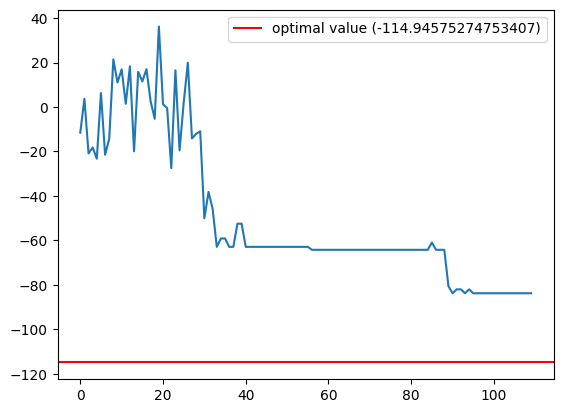

In [11]:
import matplotlib.pyplot as plt

plt.plot(dataset_y)
plt.axhline(y=optimal_value, c="r", label=f"optimal value ({optimal_value})")
plt.legend()